# <center> Тестовое задание OSA Hybrid Platform </center>

Выборка содержит 5 признаков и целевую переменную. Разделителем в файле являются запятые.
Требуется обучить на этих данных классификатор с как можно более высокой обобщающей способностью. 

Метрикой, по которой будет оцениваться качество классификатора, является ROC-AUC. Стоит заранее отметить, что если не удаётся получить ROC-AUC выше 70%, то это означает, что не придуманы какие-то сильные признаки. При этом предлагается уделить внимание не только точности классификатора, но и оформлению кода, изучению данных и грамотной оценке качества получившейся модели - всё это тоже будет оцениваться, а что-то из этого также может помочь построить более хорошую модель.

Решение необходимо сдать в виде скрипта на Python или блокнота формата Jupyter Notebook. Комментарии и графики приветствуются.


In [1]:
from __future__ import (absolute_import, division,print_function, unicode_literals)
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


###  Часть 1. Описание набора данных и признаков

In [2]:
data = pd.read_csv('dataset.csv',na_values="NaN")
data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,0.433306,-4.106981,1.252722,4.842634,7.610817,1.0
1,-0.216705,3.832332,-10.054348,-1.106758,1.987823,0.0
2,8.574821,-2.495187,5.404009,-6.219058,6.954602,1.0
3,7.673529,-4.234502,8.135008,3.748393,3.457908,0.0
4,3.548824,-2.588106,-2.095070,7.993792,-3.523852,1.0


Целевая переменная

In [3]:
y = data['target']
#del data['Default']

### Часть 2. Первичный анализ признаков

Посмотрим есть ли пропуски в данных и сколько датасет занимает в памяти

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
feature_1    3000 non-null float64
feature_2    3000 non-null float64
feature_3    3000 non-null float64
feature_4    3000 non-null float64
feature_5    3000 non-null float64
target       3000 non-null float64
dtypes: float64(6)
memory usage: 140.7 KB


По типу признака можно предположить, что в датасете присутствуют количественные(float64) признаки. Посмотрим статистику по всем признакам.

In [5]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
feature_1,3000.0,0.141861,5.433073,-12.936886,-4.095531,0.182078,4.213366,13.093660
feature_2,3000.0,0.042065,5.389536,-12.810592,-4.044539,0.082622,4.009051,13.866223
feature_3,3000.0,0.022336,5.422549,-13.454282,-4.101664,-0.024358,4.095432,13.907629
feature_4,3000.0,0.023745,5.340603,-13.194904,-4.076794,0.068921,4.136638,13.360422
feature_5,3000.0,0.025611,5.434483,-13.433194,-3.951466,0.032573,4.312101,13.649220
target,3000.0,0.600000,0.489980,0.000000,0.000000,1.000000,1.000000,1.000000


На этапе первичного анализа признаков наиболее интересны столбцы min и max, чобы посмотреть в каких признаках могут быть сильные выбросы. 

В целом минимальные / максимальные значения для каждого признака имеют близкие значения. По среднему значениюможно обратить внимание на близость  распределений feature_3/feature_4/feature_5

###  Часть 3. Первичный визуальный анализ признаков

Рассмотрим распределение числовых признаков

In [6]:
features = data.columns.values.tolist()[:-1] #без целевого признака

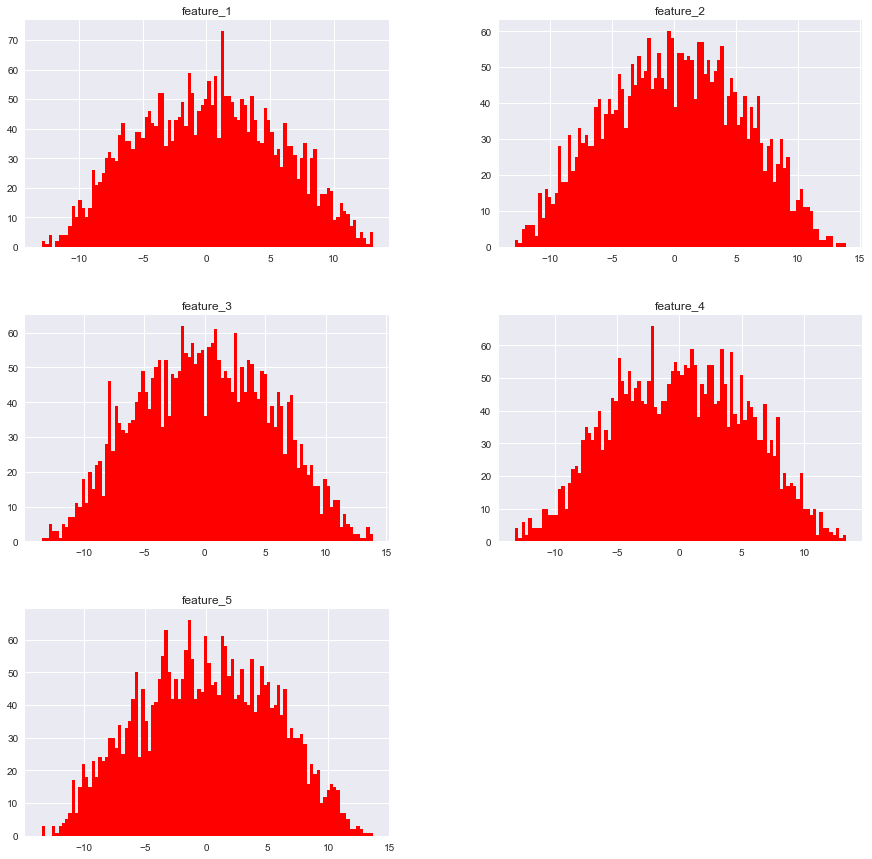

In [7]:
data[features].hist(figsize=(15, 15),bins=100,color='r');

Анализируя визуально плотность распеределения относительно средних значений можно обратить внимание  на следующую  концентрацию у значений у признаков - feature_1 - 1, feature_3 - (-8) feature_4 - (-2). Среди текущих признаков нет признаков с перекосом распределения в сторону какого-то одного значения возможно, нет необходимости логарифмировать 

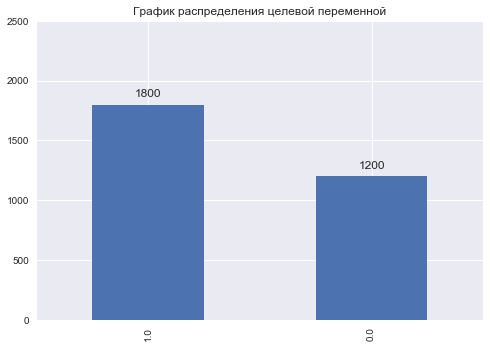

In [8]:
ax=y.value_counts(sort=False).plot(kind='bar');
rects = ax.patches
labels = y.value_counts(sort=False)
figsize(6, 6)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 50, label, ha='center', va='bottom')
    
plt.title(u"График распределения целевой переменной",fontsize=12);
plt.ylim(0,2500);

Распределение целевой переменной сбалансировано, таким образом сэмплировать данный датасет чтобы выровнять распределение классов не нужно

Визуализируем признаки попарно. Построим scatterplot для пар вещественных признаков. Указать параметр hue = дискретный целевой признак, то разные его значения будут отображаться разными цветами. Следует быт внимательным с пропусками поскольку pairplot не работает с пропусками.

Wall time: 7.04 s


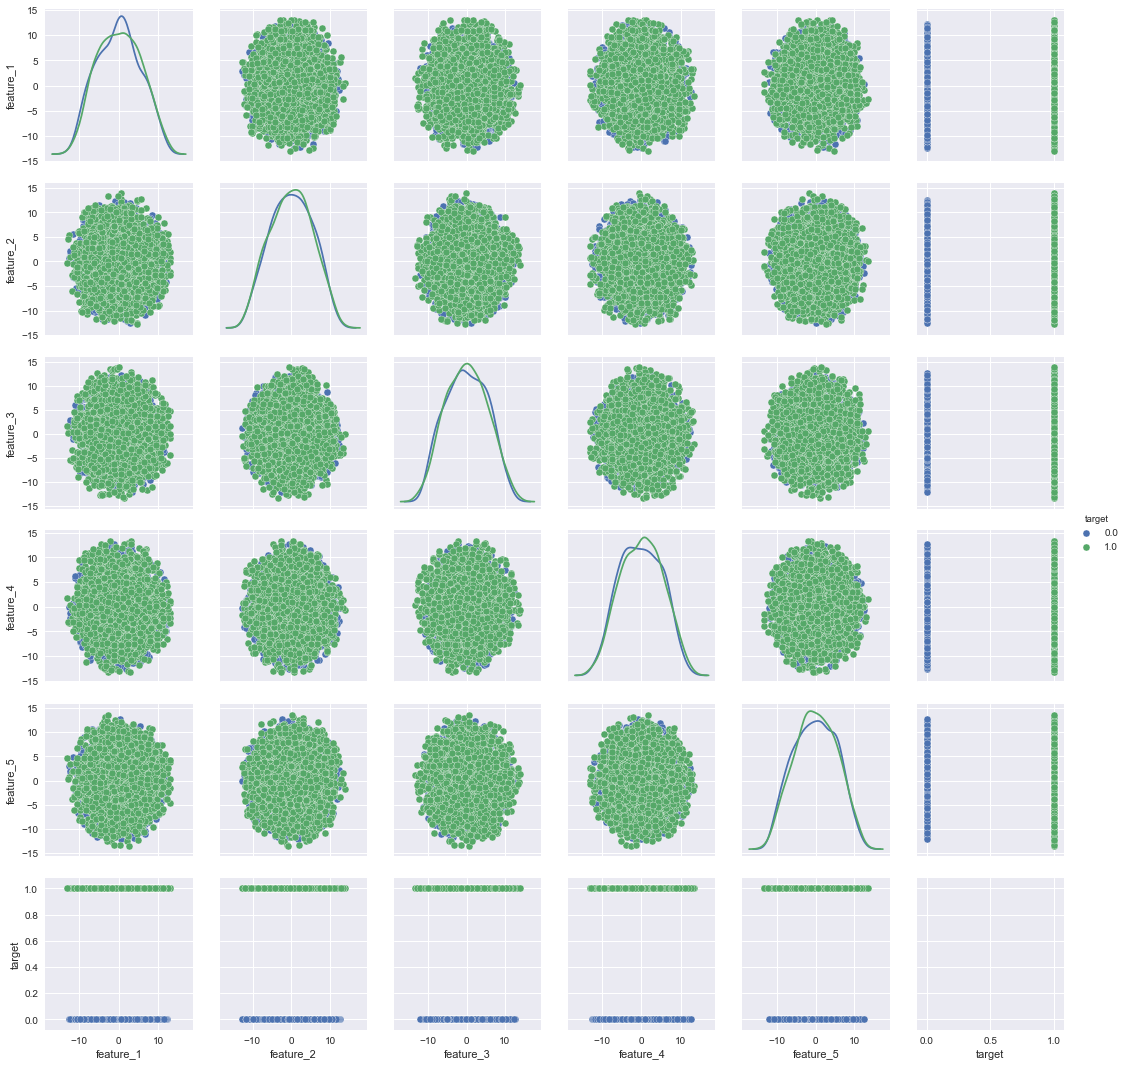

In [9]:
%%time
data_pairplot=data
data_pairplot.dropna(inplace=True)
sns.pairplot(data_pairplot,diag_kind="kde",hue='target');

Pairplot закрашивает область распределения значений последовательно, и последнее значение целевой в переменной будет в 'верхнем слое' рисунка закрашивая собой остальные предшествующие значения целеых переменных у объектов. Поэтому сложные инсайты в данных можно заметить. Рассмотрим попарные распределения некоторых признаков отдельно


In [10]:
del data_pairplot
from matplotlib.colors import ListedColormap
colors=ListedColormap(['b','g'])
def scatter_def(x1,x2):
    sns.pairplot(data,x_vars=[x1],y_vars=[x2],size=6,hue="target");
    #plt.scatter(data[x1],data[x2],alpha=0.7,c=data['y'],cmap=colors)
    plt.xlabel(x1)
    plt.ylabel(x2)
    plt.xlim(min(data[x1]),max(data[x1])*1.1)
    plt.ylim(min(data[x2]),max(data[x2])*1.1) 

Рассмотрим  более детально те признаки медианы которых не совпадают - feature_1 с любым другим

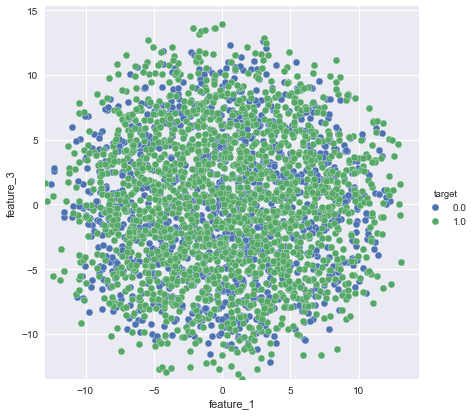

In [11]:
scatter_def('feature_1','feature_3')

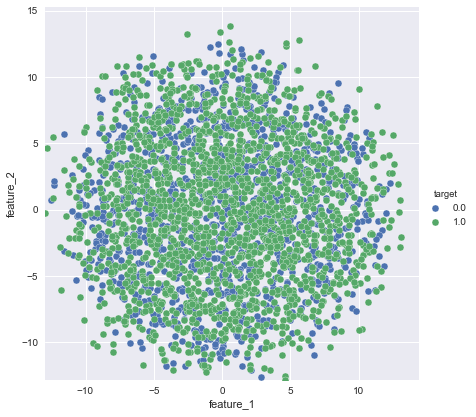

In [12]:
scatter_def('feature_1','feature_2')

###  Часть 4. Закономерности, "инсайты", особенности данных

В текущей синтетической выборке не удалось найти информацию о взаимодействии признаков друг с другом и с целевой переменной. Таким образом нет смысла перемножать  или делить признаки между собой. Возможно следует попробовать возвести  значения каждого признака в квадрат

###  Часть 5. Разбиение данных 

Разобьем выборку на обучающую и тестовую на которой будем проверять качество моделей обучения.

In [13]:
TRAIN, TEST = slice(None, int(len(data)*0.80)), slice(int(len(data)*0.80), None)
y_train=y[TRAIN]
y_test=y[TEST]

Проверим распределение классов в обучающей и отложенной подвыборках целевого признака

In [14]:
y_train.value_counts()/len(y_train)

1.0    0.601667
0.0    0.398333
Name: target, dtype: float64

In [15]:
y_test.value_counts()/len(y_test)

1.0    0.593333
0.0    0.406667
Name: target, dtype: float64

###  Часть 6. Построение признаков

**Baseline**   
В задаче требуется получить ROC-AUC выше 0,70. В качестве классификаторов будем использовать несколько моделей. Классификатор показавший лучшую оценку ROC-AUC будем использовать дальше для генерации новых признаков. Кросс-валидацию  будем проводить на 5 фолдов.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from tqdm import tqdm

C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [17]:
def GridSearchCV_(clf,dict_params, X):    
    n_folds =5
    grid = GridSearchCV(clf, dict_params, cv=n_folds, n_jobs=-1, scoring="roc_auc")
    grid.fit(X[TRAIN], y[TRAIN])
    clf_best_score = grid.best_score_
    clf_best_params = grid.best_params_
    clf_best = grid.best_estimator_
    
    print("Лучший результат %(roc_auc).3f " % {'roc_auc': clf_best_score})
    print("Лучшие параметры", clf_best_params)

In [18]:
tree_params = {'min_samples_split' : list(range(2,5)),
               'max_depth': list(range(3,20))}

gbm_params = { 'n_estimators': [100, 300, 500],
               'learning_rate':(0.1, 0.5, 1),
                'max_depth': list(range(2, 6)), 
               'min_samples_leaf': list(range(10, 31, 5))}

diapazon = [10**x for x in (list(range(-5, 5)))]
lr_params = {'C' : diapazon}
svm_params = {'C' : diapazon, 'gamma' : [10**x for x in (list(range(-5, 0)))] }

In [19]:
%%time
clf = RandomForestClassifier(random_state=7)
GridSearchCV_(clf,tree_params, data[features])

Лучший результат 0.532 
Лучшие параметры {'max_depth': 14, 'min_samples_split': 2}
Wall time: 11.4 s


In [20]:
%%time
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data[features])

Лучший результат 0.680 
Лучшие параметры {'C': 100, 'gamma': 0.01}
Wall time: 3min 2s


In [21]:
%%time
clf = GradientBoostingClassifier (random_state=7)
GridSearchCV_(clf, gbm_params, data[features])

Лучший результат 0.548 
Лучшие параметры {'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 15, 'n_estimators': 500}
Wall time: 4min 23s


In [22]:
%%time
clf = LogisticRegression (random_state=7)
GridSearchCV_(clf, lr_params, data[features])

Лучший результат 0.503 
Лучшие параметры {'C': 1e-05}
Wall time: 6.77 s


Заметно сильное отставание всем классификаторов от SVM, поэтому дальше процесс генерации новых признаков будет происходить только для SVM. Нарисуем как выглядит кривая ROC-AUC

In [23]:
def plot_ROC_curve(y_test,y_score):
    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = roc_auc_score(np.array(y_test), y_score)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right");

In [24]:
def clf_result(X,clf):
    clf.fit(X[TRAIN], y[TRAIN])   
    y_score = clf.predict_proba(X[TEST])[:, 1]
    plot_ROC_curve(y[TEST],y_score)      

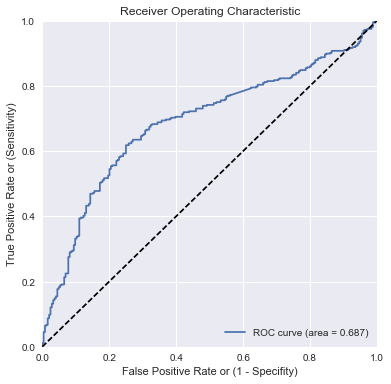

In [25]:
clf = SVC(C=100, probability=True,kernel='rbf', gamma=0.01, random_state=7 )
clf_result(data[features],clf)

**PolynomialFeatures**  
Добавим новые признаки - возведенные в квадрат старые признаки

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

In [27]:
%%time
parameter_sets = { 'svm__C' : diapazon, 'svm__gamma' : [10**x for x in (list(range(-4, 0)))] }
pipeline = Pipeline( [('poly_features', PolynomialFeatures(degree=2)),('svm', SVC(random_state=7)) ])
n_folds =5
grid = GridSearchCV(pipeline, parameter_sets, cv=n_folds, n_jobs=-1, scoring="roc_auc")
grid.fit(data[features][TRAIN], y[TRAIN])
clf_best_score = grid.best_score_
clf_best_params = grid.best_params_
   
print("Лучший результат %(roc_auc).3f " % {'roc_auc': clf_best_score})
print("Лучшие параметры", clf_best_params)

Лучший результат 0.702 
Лучшие параметры {'svm__C': 10, 'svm__gamma': 0.0001}
Wall time: 46.3 s


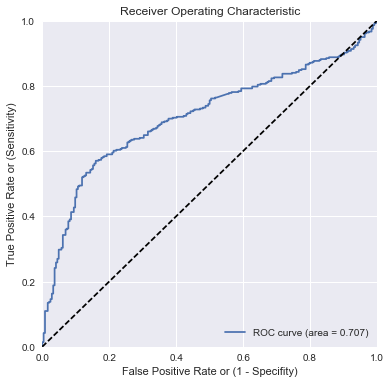

In [28]:
clf = make_pipeline(PolynomialFeatures(degree=2), SVC(C=10, probability=True,kernel='rbf', gamma=1e-04 ))
clf_result(data[features],clf)

Посмотрим новы признаки визуально - распределение и попарное взаимодействие

In [29]:
data_square = data[features].applymap(lambda x : (x*x))
data_square.columns = [ x+'*2' for x in data[features].columns.tolist()]
data_square.head()

,feature_1*2,feature_2*2,feature_3*2,feature_4*2,feature_5*2
0,0.187754,16.867292,1.569313,23.451104,57.924537
1,0.046961,14.686772,101.089914,1.224914,3.951439
2,73.527550,6.225960,29.203317,38.676680,48.366492
3,58.883054,17.931011,66.178352,14.050454,11.957129
4,12.594152,6.698292,4.389316,63.900705,12.417535


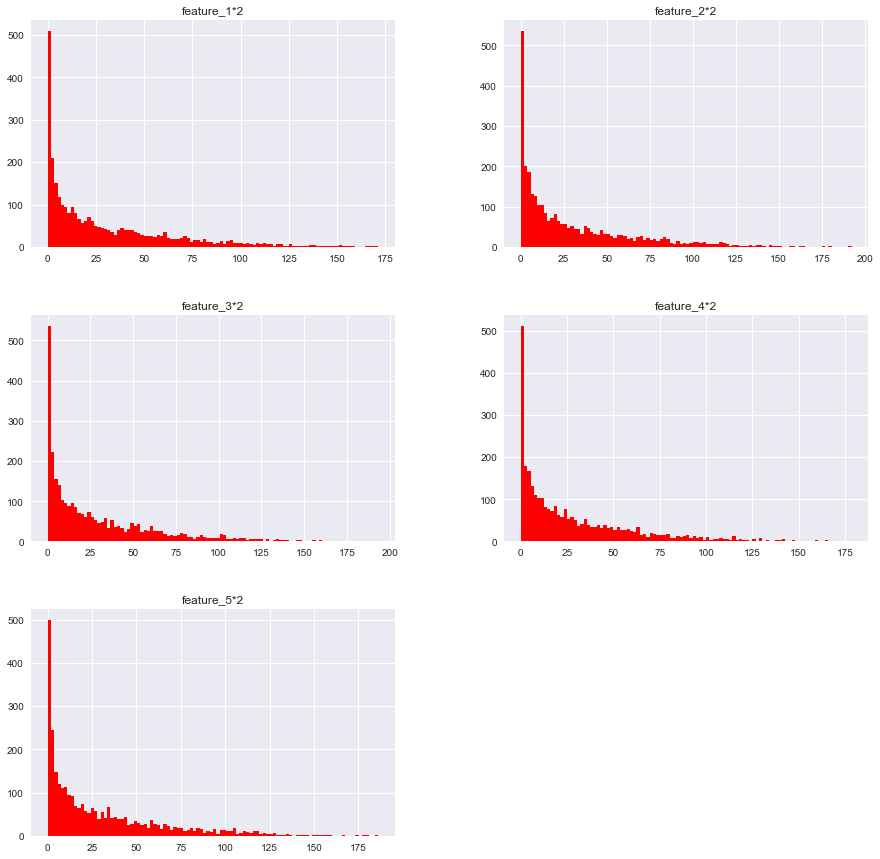

In [30]:
data_square.hist(figsize=(15, 15),bins=100,color='r');

Wall time: 6.72 s


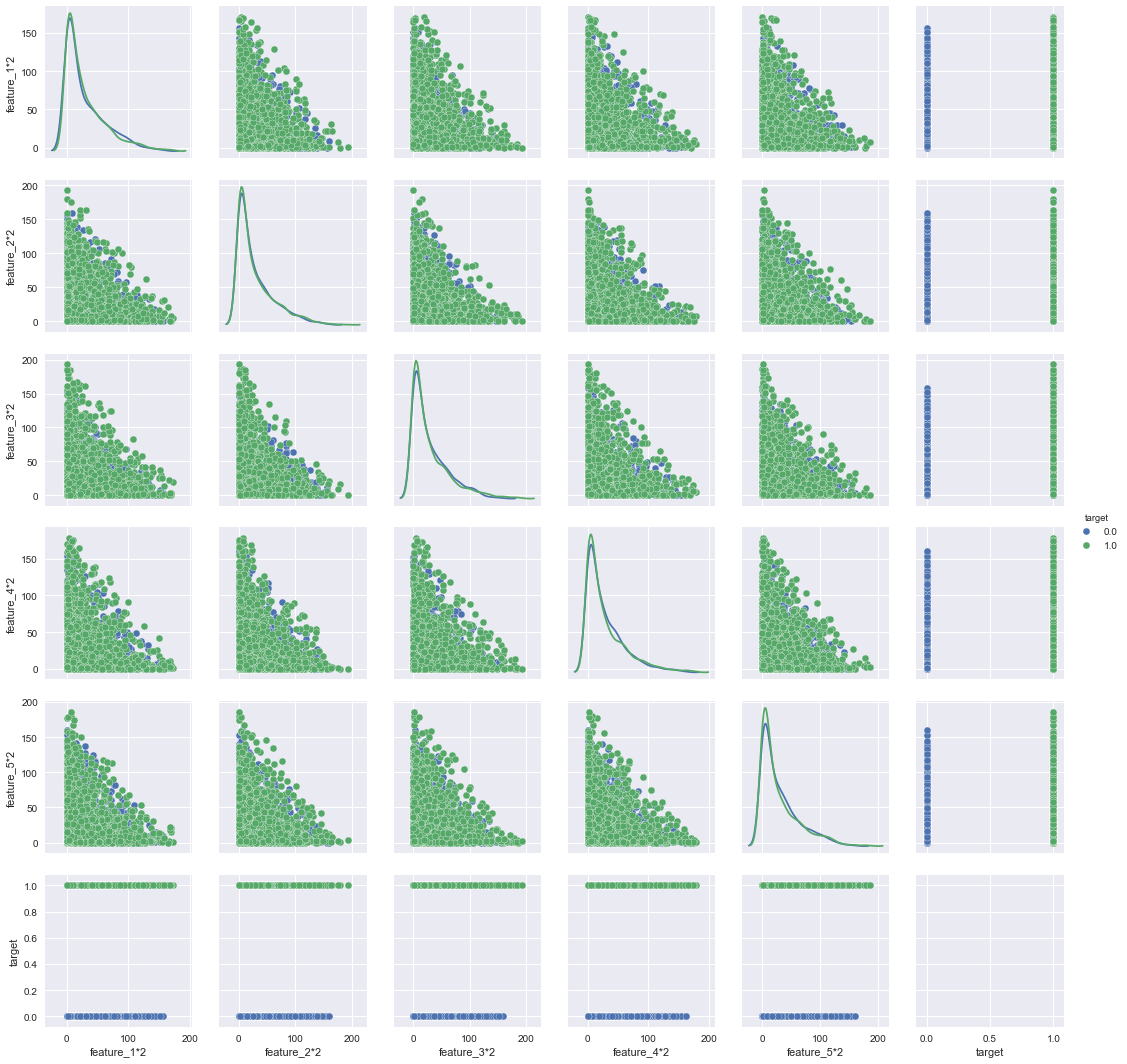

In [31]:
%%time
data_pairplot=pd.concat([data_square,data['target']], axis=1)
data_pairplot.dropna(inplace=True)
sns.pairplot(data_pairplot,diag_kind="kde",hue='target');

In [32]:
del data_pairplot # чистим память

Заметно, что существует линейная попарная зависимость между новыми признаками. Посмотрим как отловит классификатор эту зависимость и новых признаков вместе со старыми

In [33]:
%%time
data_new = pd.concat([data_square,data[features]], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.763 
Лучшие параметры {'C': 10, 'gamma': 0.01}
Wall time: 2min 30s


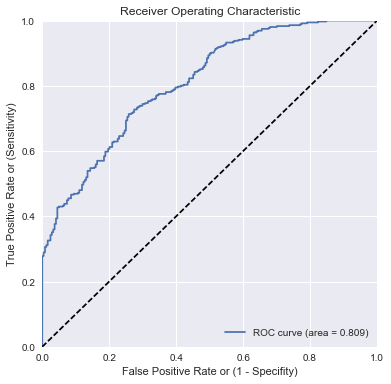

In [34]:
clf = SVC(C=10, probability=True,kernel='rbf', gamma=0.01,random_state=7 )
clf_result(data_new,clf)

**Попарные произведения признаков**

Посмотрим сколько новых признаков добавится, если генерить новый признак как признак явлющийся произведением двух признаков — это признак, значениями которого являются произведение пары (значение первого признака, значение второго признака)

In [35]:
from itertools import combinations, combinations_with_replacement
comb = list(combinations(data_square.columns, 2))
comb

[('feature_1*2', 'feature_2*2'),
 ('feature_1*2', 'feature_3*2'),
 ('feature_1*2', 'feature_4*2'),
 ('feature_1*2', 'feature_5*2'),
 ('feature_2*2', 'feature_3*2'),
 ('feature_2*2', 'feature_4*2'),
 ('feature_2*2', 'feature_5*2'),
 ('feature_3*2', 'feature_4*2'),
 ('feature_3*2', 'feature_5*2'),
 ('feature_4*2', 'feature_5*2')]

In [36]:
data_prod=pd.DataFrame()
for n in range(2,3):
    for col in combinations(data_square.columns, n):         
        new_col = 'features ' + '_'.join([x[-3:] for x in col]) 
        data_prod[new_col]=data_square[list(col)].prod(axis=1) 
data_prod.shape

(3000, 10)

In [37]:
data_prod.head()

,features 1*2_2*2,features 1*2_3*2,features 1*2_4*2,features 1*2_5*2,features 2*2_3*2,features 2*2_4*2,features 2*2_5*2,features 3*2_4*2,features 3*2_5*2,features 4*2_5*2
0,3.166909,0.294645,4.403048,10.875588,26.470059,395.556617,977.030073,36.802120,90.901723,1358.394333
1,0.689706,4.747288,0.057523,0.185564,1484.684540,17.990028,58.033886,123.826416,399.450640,4.840172
2,457.779621,2147.248364,2843.801540,3556.269673,181.818698,240.799482,301.127868,1129.487356,1412.462007,1870.655346
3,1055.832682,3896.783497,827.333619,704.072282,1186.644755,251.938836,214.403413,929.835869,791.303106,168.003088
4,84.359309,55.279718,804.775200,156.388324,29.400922,428.025578,83.176274,280.480405,54.504488,793.489228


In [38]:
%%time
data_new = pd.concat([data_prod], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.820 
Лучшие параметры {'C': 0.01, 'gamma': 1e-05}
Wall time: 44.8 s


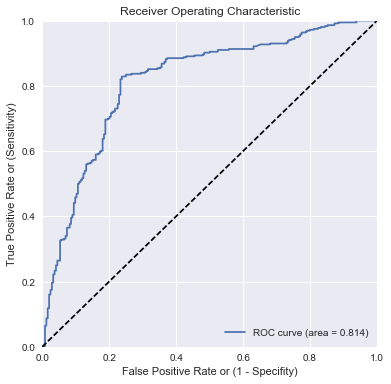

In [39]:
clf = SVC(C=0.1, probability=True,kernel='rbf', gamma=1e-05, random_state=7 )
clf_result(data_new,clf)

In [40]:
%%time
data_new = pd.concat([data_prod,data_square,data[features]], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.822 
Лучшие параметры {'C': 0.001, 'gamma': 1e-05}
Wall time: 46.8 s


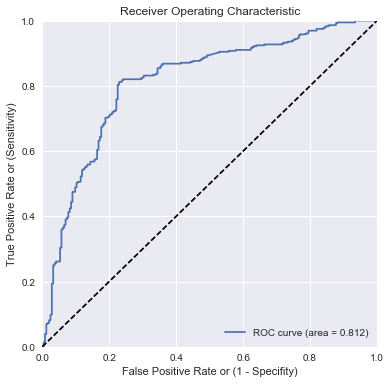

In [41]:
clf = SVC(C=0.001, probability=True,kernel='rbf', gamma=1e-05, random_state=7 )
clf_result(data_new,clf)

**Дискретизация**  
Перекодируем числовые признаки в категориальные

In [42]:
def GridSearchCV_2(clf,dict_params, X):    
    n_folds =5
    grid = GridSearchCV(clf, dict_params, cv=n_folds, n_jobs=-1, scoring="roc_auc")
    grid.fit(X[TRAIN], y[TRAIN])
    clf_best_score = grid.best_score_
    clf_best_params = grid.best_params_
    clf_best = grid.best_estimator_
    return clf_best_score, clf_best_params

In [43]:
# не перезапускалась
from tqdm import tqdm

roc_auc_list = []    
for n_ in tqdm(range (0,50)):   
    # n_  количество бинов на которые делятся числовые признаки
    data_cat = pd.DataFrame()
    for features_ in data_square.columns:
        data_cat['quantile_'+ features_] = pd.qcut(data_square[features_], n_, labels=False)

    data_cat = data_cat.applymap(lambda x: str(x) + ' cat')   
    data_new = pd.concat([pd.get_dummies(data_cat), data[features]], axis=1)   
    
    clf = SVC(random_state=7)
    roc_auc_score_ = GridSearchCV_2(clf, svm_params, data_new)
    roc_auc_list.append(roc_auc_score_) # _ иначе кофликт с roc_auc_score

100%|███████████████████████████████████████| 50/50 [1:52:49<00:00, 174.06s/it]


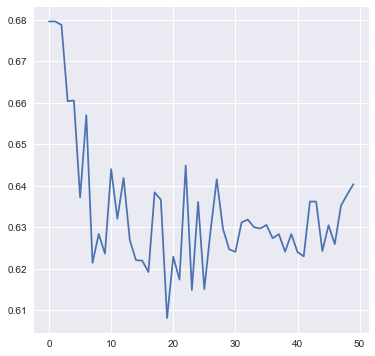

In [44]:
plot(list(zip(*roc_auc_list))[0]);

In [45]:
roc_auc_list[0]

(0.6795630331640342, {'C': 100, 'gamma': 0.01})

In [46]:
roc_auc_list = []    
for n_ in tqdm(range (1,100,2)):   
    # n_  количество бинов на которые делятся числовые признаки
    data_cat = pd.DataFrame()
    for features_ in data_square.columns:
        data_cat['bin_'+ features_] = pd.cut(data_square[features_], n_, labels=False) # qcut

    data_cat = data_cat.applymap(lambda x: str(x) + ' cat')   
    data_new = pd.concat([pd.get_dummies(data_cat), data[features]], axis=1)   
    
    clf = SVC(random_state=7)
    roc_auc_score_ = GridSearchCV_2(clf, svm_params, data_new)
    roc_auc_list.append(roc_auc_score_) # _ иначе кофликт с roc_auc_score

100%|███████████████████████████████████████| 50/50 [2:41:18<00:00, 310.51s/it]


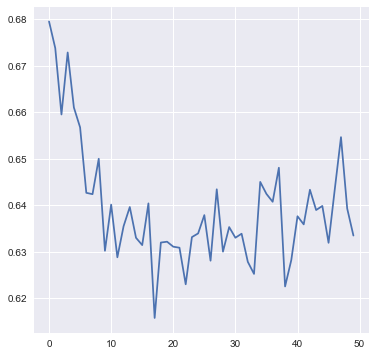

In [47]:
plot(list(zip(*roc_auc_list))[0]);

Дискретизация числовых переменных в категориальные не сработала. Возмозно использование OneHotEncoder (pd.get_dummies) создает слишком разреженную матрицу для классификатора SVM. 

In [48]:
data_cat.head()

,bin_feature_1*2,bin_feature_2*2,bin_feature_3*2,bin_feature_4*2,bin_feature_5*2
0,0 cat,8 cat,0 cat,13 cat,30 cat
1,0 cat,7 cat,51 cat,0 cat,2 cat
2,42 cat,3 cat,14 cat,21 cat,25 cat
3,34 cat,9 cat,33 cat,7 cat,6 cat
4,7 cat,3 cat,2 cat,35 cat,6 cat


In [49]:
pd.get_dummies(data_cat).shape

(3000, 454)

**Отранжированный Label encoder**

In [50]:
rank_cat=pd.Series(data_cat.values.flatten()).value_counts().rank(method = 'dense')
rank_cat[:10]

0 cat     78.0
1 cat     77.0
2 cat     76.0
3 cat     75.0
4 cat     74.0
5 cat     73.0
6 cat     72.0
7 cat     71.0
8 cat     70.0
10 cat    69.0
dtype: float64

In [51]:
len(rank_cat)

99

In [52]:
data_cat_rank = pd.DataFrame()
for col in data_cat.columns:
    data_cat_rank[col] = data_cat[col].map(rank_cat)  
data_cat_rank.head()

,bin_feature_1*2,bin_feature_2*2,bin_feature_3*2,bin_feature_4*2,bin_feature_5*2
0,78.0,70.0,78.0,67.0,48.0
1,78.0,71.0,33.0,78.0,76.0
2,39.0,75.0,64.0,56.0,57.0
3,46.0,68.0,44.0,71.0,72.0
4,71.0,75.0,76.0,45.0,72.0


In [53]:
%%time
data_new = pd.concat([data_cat_rank], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.815 
Лучшие параметры {'C': 10000, 'gamma': 0.001}
Wall time: 5min 32s


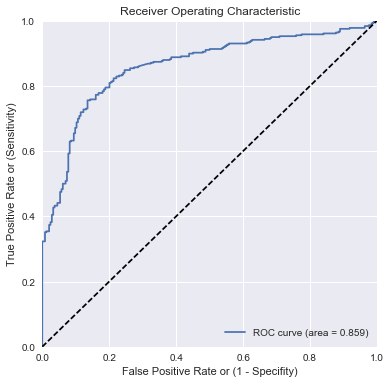

In [54]:
clf = SVC(C=10000, probability=True,kernel='rbf', gamma=1e-03, random_state=7 )
clf_result(data_new,clf)

ROC-AUC на тестовой выборке превысило предидущее максимальное значение.
Попробуем перебором определить какое  на количество бинов нужно категоризовать числовые переменные

In [55]:
roc_auc_list = []    
for n_ in tqdm(range (10,100,5)):   
    # n_  количество бинов на которые делятся числовые признаки
    data_cat = pd.DataFrame()
    for features_ in data_square.columns:
        data_cat['bin_'+ features_] = pd.cut(data_square[features_], n_, labels=False) # qcut

    data_cat = data_cat.applymap(lambda x: str(x) + ' cat')   
    
    rank_cat=pd.Series(data_cat.values.flatten()).value_counts().rank(method = 'dense')  
    data_cat_rank = pd.DataFrame()
    for col in data_cat.columns:
        data_cat_rank[col] = data_cat[col].map(rank_cat)  
        
    clf = SVC(random_state=7)
    roc_auc_score_ = GridSearchCV_2(clf, svm_params, data_cat_rank)
    roc_auc_list.append(roc_auc_score_)

100%|█████████████████████████████████████████| 18/18 [48:19<00:00, 197.81s/it]


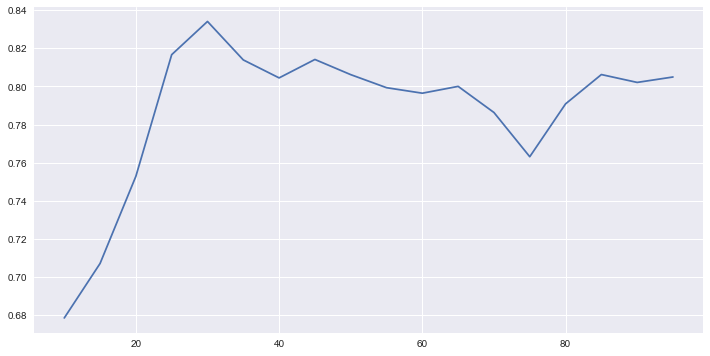

In [56]:
plt.figure(figsize=(12,6))
plot(range (10,100,5),list(zip(*roc_auc_list))[0]);

In [58]:
n_=30
data_cat = pd.DataFrame()
for features_ in data_square.columns:
    data_cat['bin_'+ features_] = pd.cut(data_square[features_], n_, labels=False) # qcut

data_cat = data_cat.applymap(lambda x: str(x) + ' cat')   
    
rank_cat=pd.Series(data_cat.values.flatten()).value_counts().rank(method = 'dense')  
data_cat_square_rank = pd.DataFrame()
for col in data_cat.columns:
    data_cat_square_rank[col] = data_cat[col].map(rank_cat) 

In [59]:
%%time
data_new = pd.concat([data_cat_square_rank], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.834 
Лучшие параметры {'C': 10000, 'gamma': 0.01}
Wall time: 3min 37s


Wall time: 4min 19s


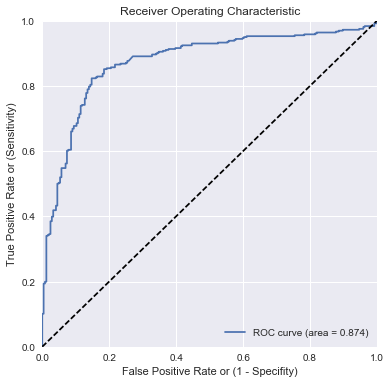

In [60]:
%%time
plt.figure(figsize=(6,6))
clf = SVC(C=10000, probability=True,kernel='rbf', gamma=0.01 , random_state=7 )
clf_result(data_new,clf)

Данный результат получен для категоризации data_square(ROC-AUC 0.809), но результат data_prod (ROC-AUC 0.812) был выше.
Попробуем проделать теже операции с data_prod

In [61]:
roc_auc_list = []    
for n_ in tqdm(range (10,100,5)):   
    # n_  количество бинов на которые делятся числовые признаки
    data_cat = pd.DataFrame()
    for features_ in data_prod.columns:
        data_cat['bin_'+ features_] = pd.cut(data_prod[features_], n_, labels=False) # qcut

    data_cat = data_cat.applymap(lambda x: str(x) + ' cat')   
    
    rank_cat=pd.Series(data_cat.values.flatten()).value_counts().rank(method = 'dense')  
    data_cat_rank = pd.DataFrame()
    for col in data_cat.columns:
        data_cat_rank[col] = data_cat[col].map(rank_cat)  
        
    clf = SVC(random_state=7)
    roc_auc_score_ = GridSearchCV_2(clf, svm_params, data_cat_rank)
    roc_auc_list.append(roc_auc_score_)

100%|█████████████████████████████████████████| 18/18 [33:48<00:00, 125.16s/it]


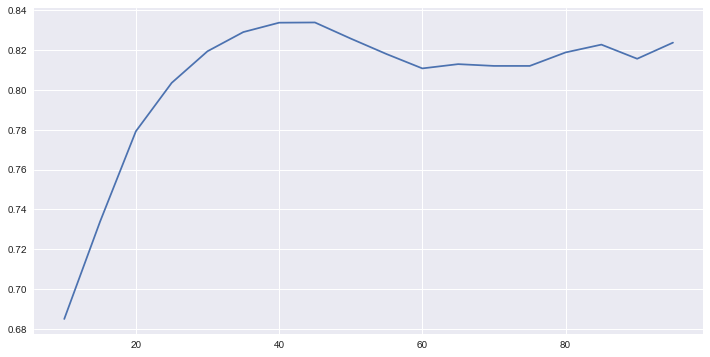

In [62]:
plt.figure(figsize=(12,6))
plot(range (10,100,5),list(zip(*roc_auc_list))[0]);

In [63]:
roc_auc_list[7]

(0.8339497589933234, {'C': 1, 'gamma': 0.1})

In [64]:
n_=40
data_cat = pd.DataFrame()
for features_ in data_prod.columns:
    data_cat['bin_'+ features_] = pd.cut(data_prod[features_], n_, labels=False) # qcut

data_cat = data_cat.applymap(lambda x: str(x) + ' cat')   
    
rank_cat=pd.Series(data_cat.values.flatten()).value_counts().rank(method = 'dense')  
data_cat_prod_rank = pd.DataFrame()
for col in data_cat.columns:
    data_cat_prod_rank[col] = data_cat[col].map(rank_cat) 

In [65]:
%%time
data_new = pd.concat([data_cat_prod_rank], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.834 
Лучшие параметры {'C': 1, 'gamma': 0.1}
Wall time: 1min 29s


Wall time: 2.05 s


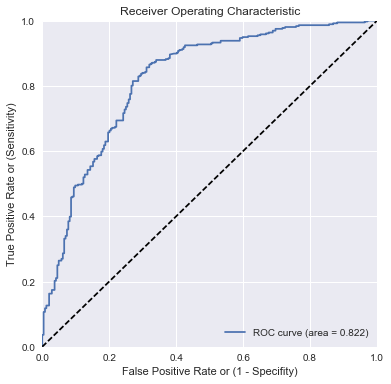

In [66]:
%%time
plt.figure(figsize=(6,6))
clf = SVC(C=1, probability=True,kernel='rbf', gamma=0.1 , random_state=7 )
clf_result(data_new,clf)

**Объединение категориальных признаков**

Посмотрим сколько новых признаков добавится, если генерить новый признак как признак явлющийся конъюнкцией двух категориальных признаков — это признак, значениями которого являются пары (значение первого признака, значение второго признака)

Проведем конкатенацию  признаков для таблицы data_cat полученной из data_prod (n_=40)

In [67]:
from itertools import combinations
comb=list(combinations(data_cat.columns, 2))
len(comb)

45

In [68]:
# создадим новый DataFrame для этих признаков
data_cat_conj=pd.DataFrame()

for col in combinations(data_cat.columns, 2):
    new_col=col[0]+'+'+col[1]
    data_cat_conj[new_col]=data_cat[col[0]]+' + '+ data_cat[col[1]]
    
#for col in combinations(data_cat.columns, 3):
#    new_col=col[0]+'+'+col[1]+'+'+col[2]
#    data_cat_conj[new_col]=data_cat[col[0]]+' + '+ data_cat[col[1]]+' + '+ data_cat[col[2]]
        
data_cat_conj.shape 

(3000, 45)

In [69]:
data_cat_conj.head()

,bin_features 1*2_2*2+bin_features 1*2_3*2,bin_features 1*2_2*2+bin_features 1*2_4*2,bin_features 1*2_2*2+bin_features 1*2_5*2,bin_features 1*2_2*2+bin_features 2*2_3*2,bin_features 1*2_2*2+bin_features 2*2_4*2,bin_features 1*2_2*2+bin_features 2*2_5*2,bin_features 1*2_2*2+bin_features 3*2_4*2,bin_features 1*2_2*2+bin_features 3*2_5*2,bin_features 1*2_2*2+bin_features 4*2_5*2,bin_features 1*2_3*2+bin_features 1*2_4*2,...,bin_features 2*2_4*2+bin_features 2*2_5*2,bin_features 2*2_4*2+bin_features 3*2_4*2,bin_features 2*2_4*2+bin_features 3*2_5*2,bin_features 2*2_4*2+bin_features 4*2_5*2,bin_features 2*2_5*2+bin_features 3*2_4*2,bin_features 2*2_5*2+bin_features 3*2_5*2,bin_features 2*2_5*2+bin_features 4*2_5*2,bin_features 3*2_4*2+bin_features 3*2_5*2,bin_features 3*2_4*2+bin_features 4*2_5*2,bin_features 3*2_5*2+bin_features 4*2_5*2
0,0 cat + 0 cat,0 cat + 0 cat,0 cat + 0 cat,0 cat + 0 cat,0 cat + 1 cat,0 cat + 4 cat,0 cat + 0 cat,0 cat + 0 cat,0 cat + 6 cat,0 cat + 0 cat,...,1 cat + 4 cat,1 cat + 0 cat,1 cat + 0 cat,1 cat + 6 cat,4 cat + 0 cat,4 cat + 0 cat,4 cat + 6 cat,0 cat + 0 cat,0 cat + 6 cat,0 cat + 6 cat
1,0 cat + 0 cat,0 cat + 0 cat,0 cat + 0 cat,0 cat + 6 cat,0 cat + 0 cat,0 cat + 0 cat,0 cat + 0 cat,0 cat + 1 cat,0 cat + 0 cat,0 cat + 0 cat,...,0 cat + 0 cat,0 cat + 0 cat,0 cat + 1 cat,0 cat + 0 cat,0 cat + 0 cat,0 cat + 1 cat,0 cat + 0 cat,0 cat + 1 cat,0 cat + 0 cat,1 cat + 0 cat
2,2 cat + 9 cat,2 cat + 12 cat,2 cat + 17 cat,2 cat + 0 cat,2 cat + 1 cat,2 cat + 1 cat,2 cat + 5 cat,2 cat + 6 cat,2 cat + 8 cat,9 cat + 12 cat,...,1 cat + 1 cat,1 cat + 5 cat,1 cat + 6 cat,1 cat + 8 cat,1 cat + 5 cat,1 cat + 6 cat,1 cat + 8 cat,5 cat + 6 cat,5 cat + 8 cat,6 cat + 8 cat
3,4 cat + 17 cat,4 cat + 3 cat,4 cat + 3 cat,4 cat + 5 cat,4 cat + 1 cat,4 cat + 0 cat,4 cat + 4 cat,4 cat + 3 cat,4 cat + 0 cat,17 cat + 3 cat,...,1 cat + 0 cat,1 cat + 4 cat,1 cat + 3 cat,1 cat + 0 cat,0 cat + 4 cat,0 cat + 3 cat,0 cat + 0 cat,4 cat + 3 cat,4 cat + 0 cat,3 cat + 0 cat
4,0 cat + 0 cat,0 cat + 3 cat,0 cat + 0 cat,0 cat + 0 cat,0 cat + 1 cat,0 cat + 0 cat,0 cat + 1 cat,0 cat + 0 cat,0 cat + 3 cat,0 cat + 3 cat,...,1 cat + 0 cat,1 cat + 1 cat,1 cat + 0 cat,1 cat + 3 cat,0 cat + 1 cat,0 cat + 0 cat,0 cat + 3 cat,1 cat + 0 cat,1 cat + 3 cat,0 cat + 3 cat


In [70]:
rank_pairs_cat=pd.Series(data_cat_conj.values.flatten()).value_counts().rank(method = 'dense')
rank_pairs_cat[:10]

0 cat + 0 cat    181.0
0 cat + 1 cat    180.0
1 cat + 0 cat    179.0
2 cat + 0 cat    178.0
0 cat + 2 cat    178.0
3 cat + 0 cat    177.0
0 cat + 3 cat    176.0
0 cat + 4 cat    175.0
4 cat + 0 cat    174.0
5 cat + 0 cat    173.0
dtype: float64

In [71]:
len(rank_pairs_cat)

826

In [72]:
for col in data_cat_conj:
    data_cat_conj[col] = data_cat_conj[col].map(rank_pairs_cat)  
data_cat_conj.head()

,bin_features 1*2_2*2+bin_features 1*2_3*2,bin_features 1*2_2*2+bin_features 1*2_4*2,bin_features 1*2_2*2+bin_features 1*2_5*2,bin_features 1*2_2*2+bin_features 2*2_3*2,bin_features 1*2_2*2+bin_features 2*2_4*2,bin_features 1*2_2*2+bin_features 2*2_5*2,bin_features 1*2_2*2+bin_features 3*2_4*2,bin_features 1*2_2*2+bin_features 3*2_5*2,bin_features 1*2_2*2+bin_features 4*2_5*2,bin_features 1*2_3*2+bin_features 1*2_4*2,...,bin_features 2*2_4*2+bin_features 2*2_5*2,bin_features 2*2_4*2+bin_features 3*2_4*2,bin_features 2*2_4*2+bin_features 3*2_5*2,bin_features 2*2_4*2+bin_features 4*2_5*2,bin_features 2*2_5*2+bin_features 3*2_4*2,bin_features 2*2_5*2+bin_features 3*2_5*2,bin_features 2*2_5*2+bin_features 4*2_5*2,bin_features 3*2_4*2+bin_features 3*2_5*2,bin_features 3*2_4*2+bin_features 4*2_5*2,bin_features 3*2_5*2+bin_features 4*2_5*2
0,181.0,181.0,181.0,181.0,180.0,175.0,181.0,181.0,169.0,181.0,...,152.0,179.0,179.0,141.0,174.0,174.0,88.0,181.0,169.0,169.0
1,181.0,181.0,181.0,169.0,181.0,181.0,181.0,180.0,181.0,181.0,...,181.0,181.0,180.0,181.0,181.0,180.0,181.0,180.0,181.0,179.0
2,100.0,64.0,35.0,178.0,168.0,168.0,135.0,128.0,104.0,21.0,...,171.0,146.0,141.0,124.0,146.0,141.0,124.0,96.0,61.0,56.0
3,21.0,129.0,129.0,111.0,154.0,174.0,123.0,129.0,174.0,25.0,...,179.0,152.0,160.0,179.0,175.0,176.0,181.0,129.0,174.0,177.0
4,181.0,176.0,181.0,181.0,180.0,181.0,180.0,181.0,176.0,176.0,...,179.0,171.0,179.0,160.0,180.0,181.0,176.0,179.0,160.0,176.0


In [73]:
%%time
data_new = pd.concat([data_cat_conj], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.800 
Лучшие параметры {'C': 10, 'gamma': 0.0001}
Wall time: 1min 14s


Wall time: 2.91 s


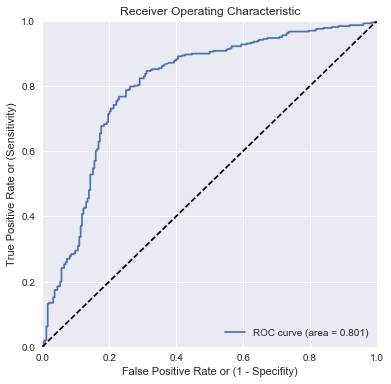

In [74]:
%%time
plt.figure(figsize=(6,6))
clf = SVC(C=10, probability=True,kernel='rbf', gamma=0.0001 , random_state=7 )
clf_result(data_new,clf)

При конкатенации также будем подбирать количество разбиений на категории

In [75]:
def Concat_cat (data):
    roc_auc_list =[]
    for n_ in tqdm(range (10,50,5)):  
        data_cat = pd.DataFrame()
        for features_ in data.columns:
            data_cat['bin_'+ features_] = pd.cut(data[features_], n_, labels=False) # qcut

        data_cat = data_cat.applymap(lambda x: str(x) + ' cat')   

        rank_cat=pd.Series(data_cat.values.flatten()).value_counts().rank(method = 'dense')  
        data_cat_rank = pd.DataFrame()
        for col in data_cat.columns:
            data_cat_rank[col] = data_cat[col].map(rank_cat) 

        # создадим новый DataFrame для этих признаков
        data_cat_conj=pd.DataFrame()
        for col in combinations(data_cat.columns, 2):
            new_col=col[0]+'+'+col[1]
            data_cat_conj[new_col]=data_cat[col[0]]+' + '+ data_cat[col[1]]

        rank_pairs_cat=pd.Series(data_cat_conj.values.flatten()).value_counts().rank(method = 'dense')   
        for col in data_cat_conj.columns:
            data_cat_conj[col] = data_cat_conj[col].map(rank_pairs_cat)    

        clf = SVC(random_state=7)
        roc_auc_score_ = GridSearchCV_2(clf, svm_params, data_cat_conj)
        roc_auc_list.append(roc_auc_score_)
    return roc_auc_list

In [76]:
roc_auc_list = Concat_cat(data_prod)

100%|████████████████████████████████████████████| 8/8 [11:17<00:00, 81.55s/it]


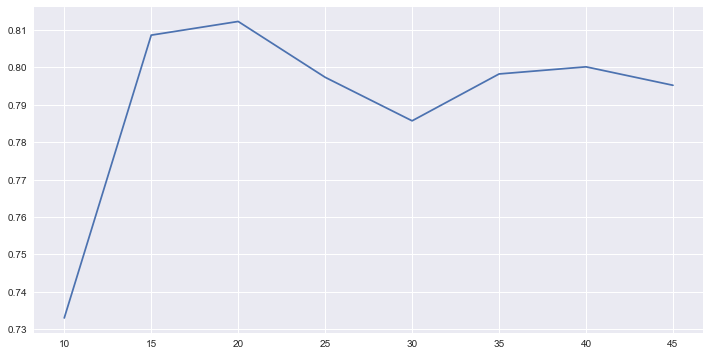

In [77]:
plt.figure(figsize=(12,6))
plot(range (10,50,5),list(zip(*roc_auc_list))[0]);

In [78]:
n_=20
data_cat = pd.DataFrame()
for features_ in data_prod.columns:
    data_cat['bin_'+ features_] = pd.cut(data_prod[features_], n_, labels=False) # qcut

data_cat = data_cat.applymap(lambda x: str(x) + ' cat')   

rank_cat=pd.Series(data_cat.values.flatten()).value_counts().rank(method = 'dense')  
data_cat_rank = pd.DataFrame()
for col in data_cat.columns:
    data_cat_rank[col] = data_cat[col].map(rank_cat) 

# создадим новый DataFrame для этих признаков
data_cat_conj_prod=pd.DataFrame()
for col in combinations(data_cat.columns, 2):
    new_col=col[0]+'+'+col[1]
    data_cat_conj_prod[new_col]=data_cat[col[0]]+' + '+ data_cat[col[1]]

rank_pairs_cat=pd.Series(data_cat_conj_prod.values.flatten()).value_counts().rank(method = 'dense')   
for col in data_cat_conj_prod.columns:
    data_cat_conj_prod[col] = data_cat_conj_prod[col].map(rank_pairs_cat) 

In [79]:
%%time
data_new = pd.concat([data_cat_conj_prod], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.812 
Лучшие параметры {'C': 1, 'gamma': 0.001}
Wall time: 1min 25s


Wall time: 2.31 s


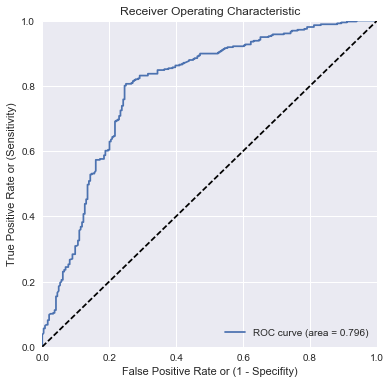

In [80]:
%%time
plt.figure(figsize=(6,6))
clf = SVC(C=1, probability=True,kernel='rbf', gamma=0.001 , random_state=7 )
clf_result(data_new,clf)

Проведем конкатенацию  признаков для таблицы data_cat полученной из data_square (n=30)

In [81]:
roc_auc_list = Concat_cat(data_square)

100%|████████████████████████████████████████████| 8/8 [12:01<00:00, 86.20s/it]


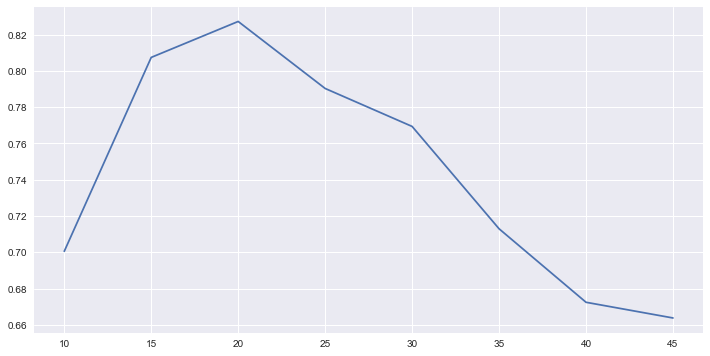

In [82]:
plt.figure(figsize=(12,6));
plot(range (10,50,5), list(zip(*roc_auc_list))[0]);

In [83]:
n_=20
data_cat = pd.DataFrame()
for features_ in data_square.columns:
    data_cat['bin_'+ features_] = pd.cut(data_square[features_], n_, labels=False) # qcut

data_cat = data_cat.applymap(lambda x: str(x) + ' cat')   

rank_cat=pd.Series(data_cat.values.flatten()).value_counts().rank(method = 'dense')  
data_cat_rank = pd.DataFrame()
for col in data_cat.columns:
    data_cat_rank[col] = data_cat[col].map(rank_cat) 

# создадим новый DataFrame для этих признаков
data_cat_conj_square=pd.DataFrame()
for col in combinations(data_cat.columns, 2):
    new_col=col[0]+'+'+col[1]
    data_cat_conj_square[new_col]=data_cat[col[0]]+' + '+ data_cat[col[1]]

rank_pairs_cat=pd.Series(data_cat_conj_square.values.flatten()).value_counts().rank(method = 'dense')   
for col in data_cat_conj_square.columns:
    data_cat_conj_square[col] = data_cat_conj_square[col].map(rank_pairs_cat) 

In [84]:
%%time
data_new = pd.concat([data_cat_conj_square], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.827 
Лучшие параметры {'C': 10, 'gamma': 0.001}
Wall time: 1min 41s


Wall time: 1.68 s


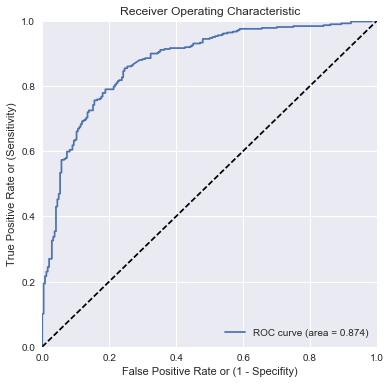

In [85]:
%%time
plt.figure(figsize=(6,6))
clf = SVC(C=10, probability=True,kernel='rbf', gamma=0.001 , random_state=7 )
clf_result(data_new,clf)

In [86]:
%%time
data_new = pd.concat([data_square, data_cat_conj_square], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.877 
Лучшие параметры {'C': 10, 'gamma': 0.001}
Wall time: 1min 15s


Wall time: 1.87 s


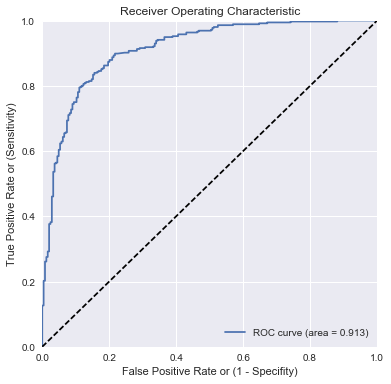

In [87]:
%%time
plt.figure(figsize=(6,6))
clf = SVC(C=10, probability=True,kernel='rbf', gamma=0.001 , random_state=7 )
clf_result(data_new,clf)

In [88]:
data_new.shape

(3000, 15)

**Cмешанное кодирование**  
У нас есть сильные числовые ии категориальные сгенерированные признаки. 

Применим смешанное кодирование - значение категориальной переменной будем кодировать средним значением числового признака по каждой уникальной переменной категориального признака.

In [89]:
def means_mapping(data, data_means,real_features, cat_features, func = 'mean'):
    if type(cat_features) != list: # groupby делается по cat_feature который м.б. как один так и несколько признаков
        cat_features = [cat_features]
    name = '{0}_by_{1}_mean'.format(real_features, cat_features)
    grp = data_means.groupby(cat_features)[[real_features]].agg(func)
    grp.columns = [name]
    # для каждой уникальной переменной будем мапить её среднее значение числового признака полученного через groupby
    return pd.merge(data[cat_features], grp, left_on = cat_features, right_index = True, how = 'left')[name]

In [90]:
data_means_map=pd.DataFrame()
data_means_=pd.concat([data_square,data_cat], axis=1) 

for best_real_features in data_square.columns:
    for col_cat_features in data_cat.columns:
        if len(data_cat[col_cat_features ].value_counts())>3:  
            # можно сразу нормировать 
            #data_means_map_= data[best_real_features]/means_mapping(best_real_features, col_cat_features)
            
            data_means_map_= means_mapping(data_means_,data_means_, best_real_features, col_cat_features)           
            data_means_map = pd.concat([data_means_map,data_means_map_], axis=1) 
            
data_means_map.fillna(mean,inplace=True)
data_means_map.shape

(3000, 25)

In [91]:
data_means_map.head()

,feature_1*2_by_['bin_feature_1*2']_mean,feature_1*2_by_['bin_feature_2*2']_mean,feature_1*2_by_['bin_feature_3*2']_mean,feature_1*2_by_['bin_feature_4*2']_mean,feature_1*2_by_['bin_feature_5*2']_mean,feature_2*2_by_['bin_feature_1*2']_mean,feature_2*2_by_['bin_feature_2*2']_mean,feature_2*2_by_['bin_feature_3*2']_mean,feature_2*2_by_['bin_feature_4*2']_mean,feature_2*2_by_['bin_feature_5*2']_mean,...,feature_4*2_by_['bin_feature_1*2']_mean,feature_4*2_by_['bin_feature_2*2']_mean,feature_4*2_by_['bin_feature_3*2']_mean,feature_4*2_by_['bin_feature_4*2']_mean,feature_4*2_by_['bin_feature_5*2']_mean,feature_5*2_by_['bin_feature_1*2']_mean,feature_5*2_by_['bin_feature_2*2']_mean,feature_5*2_by_['bin_feature_3*2']_mean,feature_5*2_by_['bin_feature_4*2']_mean,feature_5*2_by_['bin_feature_5*2']_mean
0,2.716037,32.964643,34.336388,30.914677,15.606642,35.365477,13.932963,34.739628,29.728039,18.420132,...,32.850978,30.870261,33.645323,22.068425,24.731791,35.621587,31.681590,34.117835,32.175113,60.269720
1,2.716037,32.964643,15.462157,34.949075,36.076756,35.365477,13.932963,14.973289,35.161929,33.689296,...,32.850978,30.870261,17.223212,2.897986,33.697955,35.621587,31.681590,14.476783,35.602896,2.999092
2,72.436930,34.751125,30.613035,23.938927,24.396204,18.953558,3.189945,27.896870,27.244122,25.237415,...,20.077742,34.501136,26.118881,40.108938,24.750108,16.875560,35.005335,29.115272,27.861790,51.100411
3,55.755736,32.964643,24.507532,32.633936,32.563325,21.410761,13.932963,18.523539,30.118621,33.828999,...,23.971372,30.870261,21.733964,13.036740,29.357248,20.845384,31.681590,21.434071,28.948654,13.410482
4,12.631496,34.751125,34.336388,20.868101,32.563325,31.477119,3.189945,34.739628,20.526531,33.828999,...,32.544705,34.501136,33.645323,66.342795,29.357248,35.397994,35.005335,34.117835,25.150541,13.410482


In [92]:
%%time
data_new = pd.concat([data_means_map], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.772 
Лучшие параметры {'C': 10, 'gamma': 0.01}
Wall time: 1min 42s


Wall time: 3.56 s


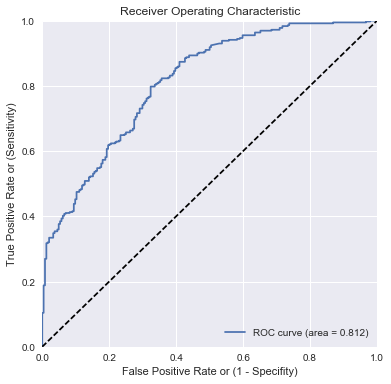

In [93]:
%%time
plt.figure(figsize=(6,6))
clf = SVC(C=10, probability=True,kernel='rbf', gamma=0.01 , random_state=7 )
clf_result(data_new,clf)

In [94]:
%%time
data_new = pd.concat([data_square, data_cat_conj_square,data_means_map], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.860 
Лучшие параметры {'C': 100, 'gamma': 0.001}
Wall time: 1min 19s


Wall time: 2.86 s


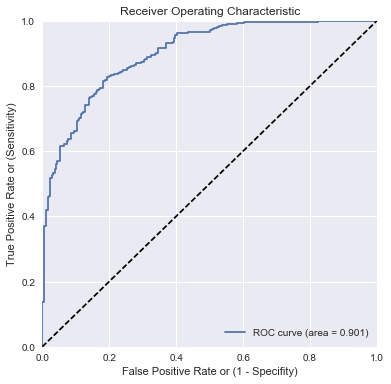

In [95]:
%%time
plt.figure(figsize=(6,6))
clf = SVC(C=100, probability=True,kernel='rbf', gamma=0.001 , random_state=7 )
clf_result(data_new,clf)

**Построение новых признаков с использованием целевой переменной**


In [96]:
class MeanClassifier():
    """
    Класс выдает среднюю вероянтность по группе подбирая значение регуляризатора по сетке
    На выходе дает предсказание out-of-fold
    Работает с DataFrame
    Параметры:
        alpha - заданное значение регуляризатора
        grid - стека значений регуляризаторов
        metric - что меряем
    """
    #  здесь зададим metric = roc_auc_score
    def __init__(self, alpha = 1, grid = None, metric = roc_auc_score):
        self.alpha = alpha
        self.grid = grid
        self.metric = metric
        
    def fit_predict(self, df, by, target, cv):
        if type(by) != list:
            by = [by]
        self.by = by
        if self.grid == None:
            grid = [self.alpha]
        else:
            grid = self.grid
        df = df[[target] + by].copy()
        df.index.name = '__id__'
        index = df.index
        df.reset_index(inplace = True)   
        df['_folds'] = cv.test_folds
        df.set_index(by + ['_folds'], inplace = True)
        
        levels = list(range(len(by)))
        levels_all = levels + [len(levels)]
        
        self.prior = df[target].mean()
        prior_fld = df.groupby(level = -1)[target].mean()
        grp = df.groupby(level = levels_all)[target].agg(['sum', 'count']) #.reset_index(level = -1)

        grp_fld = []
        for i in range(len(cv)):
            fold_stats = grp.drop(i, level = -1, axis = 0).groupby(level = levels).sum().reset_index()
            fold_stats['_folds'] = i
            fold_stats.set_index(by + ['_folds'], inplace = True)
            grp_fld.append(fold_stats)
        grp_fld = pd.concat(grp_fld)

        df = df.join(grp_fld)
        df.reset_index(inplace = True)
        df.set_index(index.name, inplace = True)
        prior_fld = df['_folds'].map(prior_fld).values
        df = df.ix[index]
        Y = df[target].values
        sum_target = df['sum'].fillna(0).values
        count_target = df['count'].fillna(0).values
        
        self.scores = []
        best_score = -np.inf
        for i in grid: 
            try:
                X = (sum_target + prior_fld * i) / (count_target + i)
                score = self.metric(Y, X)
            except ValueError:
                score = -np.inf
            if score > best_score:
                self.alpha = i
                best_pred = X
                best_score = score
            self.scores.append(score)
        self.grp = grp.groupby(level = levels).sum()
        
        return best_pred
    
    def predict(self, df):
        res = pd.merge(df[self.by], self.grp, how = 'left', left_on = self.by, right_index = True)[['sum', 'count']].fillna(0)
        return (res['sum'] + self.prior * self.alpha) / (res['count'] + self.alpha) 


In [97]:
data_cat_y = pd.concat([data_cat,y], axis=1)
data_cat_y.head()

,bin_feature_1*2,bin_feature_2*2,bin_feature_3*2,bin_feature_4*2,bin_feature_5*2,target
0,0 cat,1 cat,0 cat,2 cat,6 cat,1.0
1,0 cat,1 cat,10 cat,0 cat,0 cat,0.0
2,8 cat,0 cat,3 cat,4 cat,5 cat,1.0
3,6 cat,1 cat,6 cat,1 cat,1 cat,0.0
4,1 cat,0 cat,0 cat,7 cat,1 cat,1.0


Поскольку признак строиться с использованием целевой переменной, чтобы не было data leak необходимо  использовать фолдинг т.е. среднее значение целевой переменной для категориальной из одного фолда считать на основе значений целевой переменной для других фолдов.

In [98]:
%%time
# def fit_predict(self, df, by, target, cv)
from itertools import combinations

X_train=data_cat_y[TRAIN]
X_test=data_cat_y[TEST]
y_train= y[TRAIN] # смотрим только в целевую переменную из тренировочной выборки

from sklearn.cross_validation import StratifiedKFold
folds = StratifiedKFold(X_train['target'].values, 5, shuffle = True, random_state = 42)

it_scores = {}
added_inter = 0
data_mean_y = pd.DataFrame()

for i in range(1, 4):
    for j in combinations(data_cat.columns, i):
        by = list(j)
        name = '_'.join(by) + '_it'
        model = MeanClassifier(grid = list(np.arange(20)))

        pred = model.fit_predict(X_train, by, 'target', cv = folds)
        score = max(model.scores)        
        
        if i == 1 or score > max([it_scores[x + '_it'] for x in by]):
            data_mean_y[name] = np.hstack((pred, model.predict(X_test).values))
            added_inter += 1
        it_scores[name] = score
        # print(name, score)    

Wall time: 2.23 s


In [99]:
data_mean_y.head()

,bin_feature_1*2_it,bin_feature_2*2_it,bin_feature_3*2_it,bin_feature_4*2_it,bin_feature_5*2_it,bin_feature_2*2_bin_feature_3*2_it,bin_feature_3*2_bin_feature_4*2_it,bin_feature_3*2_bin_feature_5*2_it,bin_feature_1*2_bin_feature_2*2_bin_feature_3*2_it,bin_feature_1*2_bin_feature_3*2_bin_feature_4*2_it,bin_feature_1*2_bin_feature_3*2_bin_feature_5*2_it,bin_feature_1*2_bin_feature_4*2_bin_feature_5*2_it,bin_feature_2*2_bin_feature_3*2_bin_feature_4*2_it,bin_feature_2*2_bin_feature_3*2_bin_feature_5*2_it,bin_feature_2*2_bin_feature_4*2_bin_feature_5*2_it,bin_feature_3*2_bin_feature_4*2_bin_feature_5*2_it
0,0.584010,0.615593,0.611976,0.588537,0.593732,0.654127,0.600010,0.609337,0.715833,0.582671,0.580249,0.720166,0.537552,0.687607,0.662242,0.766805
1,0.589451,0.616455,0.635961,0.609762,0.618790,0.400208,0.630042,0.600328,0.300416,0.582310,0.537812,0.641189,0.533611,0.621840,0.690229,0.633403
2,0.618563,0.597133,0.627689,0.544749,0.632796,0.645467,0.466736,0.610039,0.266805,0.600832,0.600832,0.600832,0.371547,0.600651,0.550762,0.300416
3,0.615053,0.615593,0.529814,0.606571,0.611407,0.505307,0.688920,0.600386,0.800416,0.629344,0.600832,0.650208,0.766805,0.582499,0.506420,0.400208
4,0.573247,0.622351,0.601349,0.584470,0.609097,0.603763,0.553361,0.635494,0.550026,0.621622,0.537812,0.300416,0.564755,0.663240,0.475572,0.100139


In [100]:
data_mean_y.shape

(3000, 16)

In [101]:
%%time
data_new = pd.concat([data_mean_y], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.577 
Лучшие параметры {'C': 10000, 'gamma': 0.1}
Wall time: 37.2 s


Wall time: 16.4 s


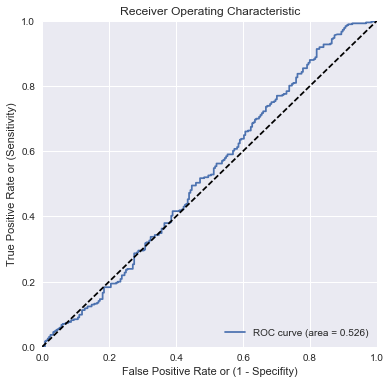

In [102]:
%%time
plt.figure(figsize=(6,6))
clf = SVC(C=10000, probability=True,kernel='rbf', gamma=0.1 , random_state=7 )
clf_result(data_new,clf)

Попробуем усилить категориальные признаки через конкатенацию друг с другом

In [103]:
data_cat_conj_y=pd.DataFrame()
for col in combinations(data_cat.columns, 2):
    new_col=col[0]+'+'+col[1]
    data_cat_conj_y[new_col]=data_cat[col[0]]+' + '+ data_cat[col[1]]
        
data_cat_conj_y.shape 

(3000, 10)

In [104]:
data_cat_conj_y.head()

,bin_feature_1*2+bin_feature_2*2,bin_feature_1*2+bin_feature_3*2,bin_feature_1*2+bin_feature_4*2,bin_feature_1*2+bin_feature_5*2,bin_feature_2*2+bin_feature_3*2,bin_feature_2*2+bin_feature_4*2,bin_feature_2*2+bin_feature_5*2,bin_feature_3*2+bin_feature_4*2,bin_feature_3*2+bin_feature_5*2,bin_feature_4*2+bin_feature_5*2
0,0 cat + 1 cat,0 cat + 0 cat,0 cat + 2 cat,0 cat + 6 cat,1 cat + 0 cat,1 cat + 2 cat,1 cat + 6 cat,0 cat + 2 cat,0 cat + 6 cat,2 cat + 6 cat
1,0 cat + 1 cat,0 cat + 10 cat,0 cat + 0 cat,0 cat + 0 cat,1 cat + 10 cat,1 cat + 0 cat,1 cat + 0 cat,10 cat + 0 cat,10 cat + 0 cat,0 cat + 0 cat
2,8 cat + 0 cat,8 cat + 3 cat,8 cat + 4 cat,8 cat + 5 cat,0 cat + 3 cat,0 cat + 4 cat,0 cat + 5 cat,3 cat + 4 cat,3 cat + 5 cat,4 cat + 5 cat
3,6 cat + 1 cat,6 cat + 6 cat,6 cat + 1 cat,6 cat + 1 cat,1 cat + 6 cat,1 cat + 1 cat,1 cat + 1 cat,6 cat + 1 cat,6 cat + 1 cat,1 cat + 1 cat
4,1 cat + 0 cat,1 cat + 0 cat,1 cat + 7 cat,1 cat + 1 cat,0 cat + 0 cat,0 cat + 7 cat,0 cat + 1 cat,0 cat + 7 cat,0 cat + 1 cat,7 cat + 1 cat


In [106]:
%%time
# def fit_predict(self, df, by, target, cv)
from itertools import combinations

X_train=pd.concat([data_cat_conj_y,y], axis=1)[TRAIN] # должен быть столбец с целевой переменной
X_test= pd.concat([data_cat_conj_y,y], axis=1)[TEST]   #
y_train= y[TRAIN] # смотрим только в целевую переменную из тренировочной выборки

from sklearn.cross_validation import StratifiedKFold
folds = StratifiedKFold(X_train['target'].values, 3, shuffle = True, random_state = 42)

it_scores = {}
added_inter = 0
data_mean_y = pd.DataFrame()

for i in range(1, 5):
    for j in combinations(data_cat_conj_square.columns, i):
        by = list(j)
        name = '_'.join(by) + '_it'
        model = MeanClassifier(grid = list(np.arange(20)))

        pred = model.fit_predict(X_train, by, 'target', cv = folds)
        score = max(model.scores)
        
        
        if i == 1 or score > max([it_scores[x + '_it'] for x in by]):
            data_mean_y[name] = np.hstack((pred, model.predict(X_test).values))
            added_inter += 1
        it_scores[name] = score   

Wall time: 35.7 s


In [107]:
data_mean_y.shape

(3000, 365)

In [108]:
%%time
data_new = pd.concat([data_mean_y], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.659 
Лучшие параметры {'C': 10000, 'gamma': 0.0001}
Wall time: 4min 8s


Wall time: 13.3 s


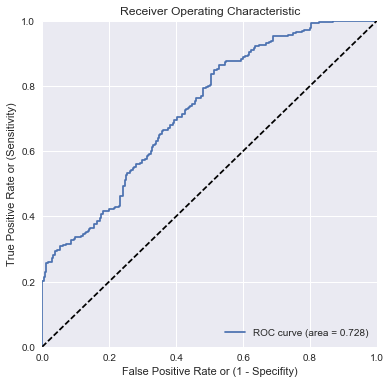

In [109]:
%%time
plt.figure(figsize=(6,6))
clf = SVC(C=10000, probability=True,kernel='rbf', gamma=0.0001 , random_state=7 )
clf_result(data_new,clf)

###  Часть 7. Финальная модель

In [116]:
import pickle
data_list = [data_square, data_prod, data_cat_square_rank, data_cat_prod_rank, data_cat_conj_square, \
        data_cat_conj_prod, data_means_map, data_mean_y]

data_name = ['data_square', 'data_prod', 'data_cat_square_rank', 'data_cat_prod_rank', 'data_cat_conj_square', \
        'data_cat_conj_prod', 'data_means_map', 'data_mean_y']

for data,name in zip (data_list,data_name):
    with open(name + '.pickle', 'wb') as f:
        pickle.dump(data, f)

In [123]:
# перезаписывает data в MeanClassifier(
data = pd.read_csv('dataset.csv',na_values="NaN")
features = data.columns.values.tolist()[:-1] #без целевого признака

Выберем самые сильные сгенерированные признаки и перебром установим комбинация каких получается максимальный ROC-AUC. Максимальное количество вариантов разных признаков (количество таблиц) установим равным 3.

In [152]:
from itertools import combinations
comb=list(combinations(data_list, 3))
print (len(comb))
del comb

56


In [159]:
%%time
roc_auc_list =[]
for data,name in tqdm(zip (combinations(data_list, 3), combinations(data_name, 3))): 
    #print (name)
    data_new = pd.concat([*data], axis=1)
    clf = SVC(random_state=7)   
    roc_auc_score_ = GridSearchCV_2(clf, svm_params, data_new)
    roc_auc_list.append([roc_auc_score_,name])

56it [2:21:34, 240.43s/it]


Wall time: 2h 21min 34s


In [162]:
with open('roc_auc_list.pickle', 'wb') as f:
    pickle.dump(roc_auc_list, f)

In [169]:
for roc_auc_score_, name in roc_auc_list:
    if roc_auc_score_[0]> 0.940:
        print(roc_auc_score_, name)

(0.9478464556224977, {'C': 10, 'gamma': 0.001}) ('data_square', 'data_cat_square_rank', 'data_cat_conj_prod')
(0.9461694302601806, {'C': 10, 'gamma': 0.001}) ('data_square', 'data_cat_prod_rank', 'data_cat_conj_prod')
(0.9593448856715524, {'C': 10, 'gamma': 0.001}) ('data_square', 'data_cat_conj_square', 'data_cat_conj_prod')
(0.9590159760315665, {'C': 10, 'gamma': 0.001}) ('data_square', 'data_cat_conj_prod', 'data_means_map')
(0.9477809190845178, {'C': 10, 'gamma': 0.001}) ('data_square', 'data_cat_conj_prod', 'data_mean_y')
(0.9403528627591254, {'C': 10, 'gamma': 0.001}) ('data_cat_square_rank', 'data_cat_conj_prod', 'data_means_map')
(0.9493547975935597, {'C': 100, 'gamma': 0.001}) ('data_cat_conj_square', 'data_cat_conj_prod', 'data_means_map')


**лучшая на тренировочной выборке модель**

In [170]:
%%time
data_new = pd.concat([ data_square, data_cat_conj_square, data_cat_conj_prod ], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.959 
Лучшие параметры {'C': 10, 'gamma': 0.001}
Wall time: 1min 36s


Wall time: 3.93 s


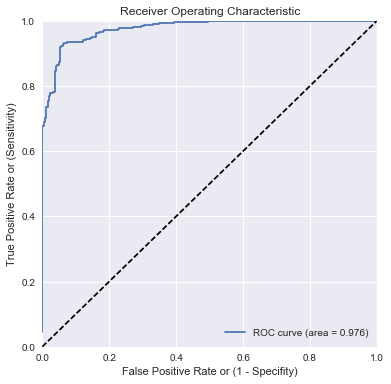

In [171]:
%%time
plt.figure(figsize=(6,6))
clf = SVC(C=10, probability=True,kernel='rbf', gamma=0.001 , random_state=7 )
clf_result(data_new,clf)

**вторая и третьтья модели по ROC-AUC на тренировочной выборке**

In [172]:
%%time
data_new = pd.concat([ data_square, data_cat_conj_prod, data_means_map ], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.959 
Лучшие параметры {'C': 10, 'gamma': 0.001}
Wall time: 1min 49s


Wall time: 4.34 s


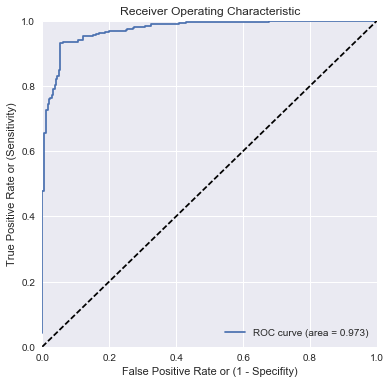

In [173]:
%%time
plt.figure(figsize=(6,6))
clf = SVC(C=10, probability=True,kernel='rbf', gamma=0.001 , random_state=7 )
clf_result(data_new,clf)

In [175]:
%%time
data_new = pd.concat([ data_square, data_cat_square_rank, data_cat_conj_prod], axis=1)
clf = SVC(random_state=7)
GridSearchCV_(clf, svm_params, data_new)

Лучший результат 0.948 
Лучшие параметры {'C': 10, 'gamma': 0.001}
Wall time: 1min 31s


Wall time: 3.17 s


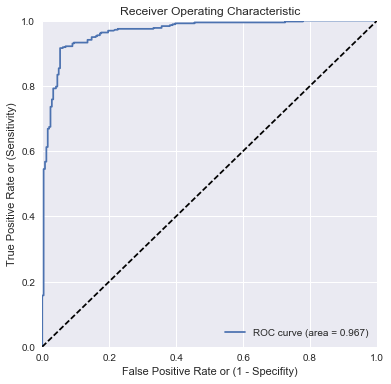

In [176]:
%%time
plt.figure(figsize=(6,6))
clf = SVC(C=10, probability=True,kernel='rbf', gamma=0.001 , random_state=7 )
clf_result(data_new,clf)